In [3]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

import contractions
import unicodedata
import re
import inflect
import pickle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, confusion_matrix

import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

Using TensorFlow backend.


In [4]:
df = pd.read_csv("./../Data/Train_Data/train.csv")

In [5]:
df.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [ ]:
# del df['humor_rating']
# del df['humor_controversy']
# del df['offense_rating']

In [6]:
def denoise_text(text):
    text = contractions.fix(text)
    return text

In [7]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [8]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

In [9]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

In [10]:
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

In [11]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

In [12]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [13]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [14]:
def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    #words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [15]:
# Testing the functions
print("remove_non_ascii results: ", remove_non_ascii(['h', 'ॐ', '©', '1']))
print("to_lowercase results: ", to_lowercase(['HELLO', 'hiDDen', 'wanT', 'GOING']))
print("remove_punctuation results: ", remove_punctuation(['hello!!', 'how?', 'done,']))
print("replace_numbers results: ", replace_numbers(['1', '2', '3']))
print("remove_stopwords results: ", remove_stopwords(['this', 'and', 'amazing']))
print("stem_words results: ", stem_words(['beautiful', 'flying', 'waited']))
print("lemmatize_verbs results: ", lemmatize_verbs(['hidden', 'walking', 'ran']))
print("normalize_text results: ", normalize_text(['hidden', 'in', 'the', 'CAVES', 'he', 'WAited', '2', 'ॐ', 'hours!!']))

remove_non_ascii results:  ['h', '', '', '1']
to_lowercase results:  ['hello', 'hidden', 'want', 'going']
remove_punctuation results:  ['hello', 'how', 'done']
replace_numbers results:  ['one', 'two', 'three']
remove_stopwords results:  ['amazing']
stem_words results:  ['beauty', 'fly', 'wait']
lemmatize_verbs results:  ['hide', 'walk', 'run']
normalize_text results:  ['hide', 'cav', 'wait', '2', 'hour']


In [16]:
def tokenize(text):
    return nltk.word_tokenize(text)

In [17]:
def text_prepare(text):
    text = denoise_text(text)
    text = ' '.join([x for x in normalize_text(tokenize(text))])
    return text

In [19]:
df['text'] = [text_prepare(x) for x in df['text']]

In [20]:
df.head(10)

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,ten best stat nobody ev com clos elev walk roo...,1,2.42,1.0,0.20
1,2,man insert advert class wif want next day rece...,1,2.50,1.0,1.10
2,3,many men tak op beer non op tim bring couch,1,1.95,0.0,2.40
3,4,tell mom hit 1200 twit follow point broth own ...,1,2.11,1.0,0.00
4,5,ros dead lov fak wed bas fun cak,1,2.78,0.0,0.10
5,6,trabajo span word work com latin term trepali ...,0,NaN,NaN,0.00
6,7,enrol skil train extr curricul act ad shap wee...,0,NaN,NaN,0.10
7,8,origin tru on kind also hold glass whit win lo...,1,1.79,1.0,0.00
8,9,men ejac 21 tim mon low risk prost cant ejac f...,0,NaN,NaN,0.05
9,10,get real angry today noth go tak word,0,NaN,NaN,0.15


In [21]:
df.to_csv('./../Data/preprocessed_train_data.csv')

In [26]:
def prepare_model_input(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]
    embeddings_dict = {}
    f = open("./../Data/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)

In [27]:
## Check function
x_train_sample = ["Lorem Ipsum is simply dummy text of the printing and typesetting industry", "It is a long established fact that a reader will be distracted by the readable content of a page when looking at its layout"]
x_test_sample = ["I’m creating a macro and need some text for testing purposes", "I’m designing a document and don’t want to get bogged down in what the text actually says"]
X_train_Glove_s, X_test_Glove_s, word_index_s, embeddings_dict_s = prepare_model_input(x_train_sample, x_test_sample, 100, 20)
print("\n X_train_Glove_s \n ", X_train_Glove_s)
print("\n X_test_Glove_s \n ", X_test_Glove_s)
print("\n Word index of the word testing is : ", word_index_s["testing"])
print("\n Embedding for the word want \n \n", embeddings_dict_s["want"])

Found 51 unique tokens.
(4, 20)
Total 400000 word vectors.

 X_train_Glove_s 
  [[ 0  0  0  0  0  0  0  0  8  9  5 10 11  2  6  3 12  4 13 14]
 [17 18 19  1 20 21 22 23 24  3 25 26  6  1 27 28 29 30 31 32]]

 X_test_Glove_s 
  [[ 0  0  0  0  0  0  0  0  0  7 33  1 34  4 35 36  2 37 38 39]
 [ 0  0  0  7 40  1 41  4 42 43 44 45 46 47 48 49  3  2 50 51]]

 Word index of the word testing is :  38

 Embedding for the word want 
 
 [ 0.13627  -0.054478  0.3703   -0.41574   0.60568  -0.42729  -0.50151
  0.35923  -0.49154   0.21827  -0.15193   0.52536  -0.24206   0.023875
  0.8225    1.089     0.98825  -0.17803   0.77806  -1.0647   -0.28742
  0.50458   0.21612   0.65681   0.34295  -2.1084   -0.82557  -0.31966
  0.87567  -1.0679    3.3802    1.2084   -1.272    -0.15921  -0.25237
 -0.2696   -0.18756  -0.35523   0.084172 -0.56539  -0.24081   0.15926
  0.3287    0.54591   0.29897   0.18948  -0.57113   0.17399  -0.19338
  0.51921 ]


In [29]:
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequebtial model
    model = Sequential()
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    for i in range(0,hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))
        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))
    model.add(Dropout(dropout))
    # Add the fully connected layer with 256 nurons and relu activation
    model.add(Dense(256, activation='relu'))
    # Add the output layer with softmax activation since we have 2 classes
    model.add(Dense(nclasses, activation='softmax'))
    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [30]:
X = df.text
y = df.is_humor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train,X_test)
print("Done!")
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Preparing model input ...
Found 9136 unique tokens.
(8000, 500)
Total 400000 word vectors.
Done!
Building Model!
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           456850    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 64)           21248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 64)           24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 500, 64)           24832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 64)          

In [27]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }
def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [28]:
history = model.fit(X_train_Glove, y_train,
                           validation_data=(X_test_Glove,y_test),
                           epochs=5,
                           batch_size=128,
                           verbose=1)


Train on 6400 samples, validate on 1600 samples
Epoch 1/5
6400/6400 [==============================] - 296s 46ms/step - loss: 0.6489 - accuracy: 0.6333 - val_loss: 0.5839 - val_accuracy: 0.7050
Epoch 2/5
6400/6400 [==============================] - 265s 41ms/step - loss: 0.5339 - accuracy: 0.7422 - val_loss: 0.4788 - val_accuracy: 0.7769
Epoch 3/5
6400/6400 [==============================] - 258s 40ms/step - loss: 0.4502 - accuracy: 0.7986 - val_loss: 0.4434 - val_accuracy: 0.8031
Epoch 4/5
6400/6400 [==============================] - 287s 45ms/step - loss: 0.3704 - accuracy: 0.8427 - val_loss: 0.4301 - val_accuracy: 0.8131
Epoch 5/5
6400/6400 [==============================] - 355s 55ms/step - loss: 0.3150 - accuracy: 0.8706 - val_loss: 0.4222 - val_accuracy: 0.8244


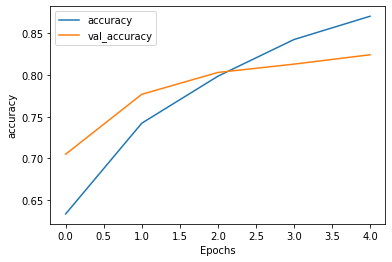

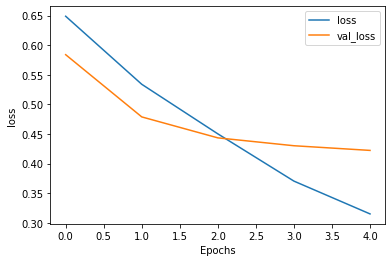

In [31]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [38]:
print("\n Evaluating Model ... \n")
predicted = model.predict_classes(X_test_Glove)
print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 



INFO:logger:  mcc = 0.6310253930977203
INFO:logger:  true positive = 835
INFO:logger:  true negative = 484
INFO:logger:  false positive = 137
INFO:logger:  false negative = 144
INFO:logger:  pricision = 0.8590534979423868
INFO:logger:  recall = 0.8529111338100103
INFO:logger:  F1 = 0.8559712967708868
INFO:logger:  accuracy = 0.824375


              precision    recall  f1-score   support

           0       0.77      0.78      0.78       621
           1       0.86      0.85      0.86       979

    accuracy                           0.82      1600
   macro avg       0.81      0.82      0.82      1600
weighted avg       0.82      0.82      0.82      1600



